# Basic prediction modelling of the probability of default on credit card clients

This notebook applies the most basic version of a set of Machine Learning algorithms on predicting the probability of default on credit card clients. The models applied are:
- logistic regression
- AdaBoost
- random forest

The three methods are implemented in their most basic form, with pre-determined hyperparameter values. Their performance is evaluated through the accuracy score and the confusion matrix.

After implementing the basic models, the random forest is expanded. GridSearch is used to find the optimal parameters, which is done for a model on which feature engineering is applied as well as on one where there isn't.

# Initialize and get the data

First, the needed libraries are initialized and the function for visualizing the results are created; an overlay histogram and a nice graphical confusion matrix. Additionally, the data is read.
 graphical confusion matrix, and read the data.

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import itertools
import matplotlib.pyplot as plt
from pprint import pprint
import os
%matplotlib inline

In [2]:
def draw_histogram(varname):
    x0=df[varname][df.Y==0]
    x1=df[varname][df.Y==1]
    count0, bin_limits = np.histogram(x0,bins=30)
    count1, _          = np.histogram(x1,bins=bin_limits)
    plt.hist(x0,bins=bin_limits,color='LightBlue')
    plt.hist(x1,bins=bin_limits,color='DarkRed')
    count_tot=count0+count1
    with np.errstate(divide='ignore',invalid='ignore'):
        count0rel=np.where(count_tot==0,np.nan,count0/(count0+count1))
        count1rel=np.where(count_tot==0,np.nan,count1/(count0+count1))
    labels=np.round((bin_limits[1:]+bin_limits[:-1])/2,1)    # determine middle of classes
    DataFrame({'0':count0rel,'1':count1rel},index=labels)[['1','0']].plot.bar(stacked=True,color=('DarkRed','LightBlue'));

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Loading in the data
data_path = os.path.join(os.getcwd(), 'data\\credit_card_default_data.csv')
df = pd.read_csv(data_path)
df_labels=['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3',
'BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default payment next month']
df.columns
df_t=df['Y']                # select target variabel (as pandas series)
df_X=df.loc[:,'X1':'X23']   # select features (as pandas dataframe)

## Rate of default: around 22%

0.0    0.78012
1.0    0.21988
Name: Y, dtype: float64


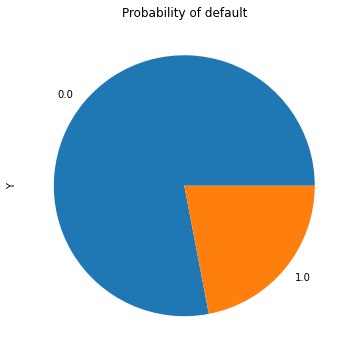

In [3]:
freq=df_t.value_counts()/(len(df_t)-df_t.isnull().sum())
freq.plot(kind='pie',title='Probability of default',figsize=(6, 6)); 
print(freq)

## Definition of variables

The target variable is a binary variable, default payment (Yes = 1, No = 0), as the response variable `t` in October 2005 from an important bank in Taiwan. The data consist of the following 23 variables as explanatory variables: 

- `X1`: Amount of the given credit (NT dollar=New Taiwan $): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- `X2`: Gender (1 = male; 2 = female). 
- `X3`: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- `X4`: Marital status (1 = married; 2 = single; 3 = others). 
- `X5`: Age (years). 
- `X6 - X11`: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: `X6` = the repayment status in September, 2005; `X7` = the repayment status in August, 2005; . . .;`X11` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- `X12-X17`: Amount of bill statement (NT dollar). `X12` = amount of bill statement in September, 2005; `X13` = amount of bill statement in August, 2005; . . .; `X17` = amount of bill statement in April, 2005. 
- `X18-X23`: Amount of previous payment (NT dollar). `X18` = amount paid in September, 2005; `X19` = amount paid in August, 2005; . . .;`X23` = amount paid in April, 2005. 

# Creating features

The variables `X2`-`X4` are dummified. We start with `X1` and add columns to the dataframe.
Next, the non-dummy variables are standardized. A description of the data is shown below.

In [4]:
data=pd.DataFrame(df['X1'],columns=['X1'])
X2_dum=pd.get_dummies(df['X2'], prefix='X2',drop_first=True)
data=pd.merge(data,X2_dum,left_index=True, right_index=True)
X3_dum=pd.get_dummies(df['X3'], prefix='X3',drop_first=True)
data=pd.merge(data,X3_dum,left_index=True, right_index=True)
X4_dum=pd.get_dummies(df['X4'], prefix='X4',drop_first=True)
data=pd.merge(data,X4_dum,left_index=True, right_index=True)


In [5]:
data=pd.merge(data,df.loc[:,'X5':'X23'],left_index=True, right_index=True)

#Standardize data
cols = list(data.columns)
for col in cols:   # loop over all columns
    if np.abs(data[col].mean())>1:    # check if dummy
        data[col] = (data[col] - data[col].mean())/data[col].std(ddof=1)   # no dummy: than standardize
t=df_t.values   # convert to numpy array
X=data.values   # convert to numpy matrix
Xlabels=data.columns
data.describe()

,X1,X2_2,X3_1,X3_2,X3_3,X3_4,X3_5,X3_6,X4_1,X4_2,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04
mean,-9.616012e-17,0.603733,0.352833,0.467667,0.163900,0.004100,0.009333,0.001700,0.455300,0.532133,...,6.134352e-17,6.702786e-17,-2.534269e-17,1.515825e-17,1.894781e-18,1.956953e-17,2.297422e-17,1.361874e-17,-9.947598e-18,-9.473903e-18
std,1.000000e+00,0.489129,0.477859,0.498962,0.370191,0.063901,0.096159,0.041197,0.498006,0.498975,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.213774e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.945623e+00,-3.314993e+00,-2.000840e+00,-6.355141e+00,-3.419359e-01,-2.569852e-01,-2.967963e-01,-3.080574e-01,-3.141309e-01,-2.933772e-01
25%,-9.054832e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.394708e-01,-6.363187e-01,-6.340494e-01,-6.316233e-01,-2.815614e-01,-2.208321e-01,-2.746460e-01,-2.891632e-01,-2.976042e-01,-2.867536e-01
50%,-2.118290e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,-3.882465e-01,-3.763388e-01,-3.652622e-01,-3.660664e-01,-2.151494e-01,-1.697923e-01,-1.945640e-01,-2.123096e-01,-2.159525e-01,-2.090007e-01
75%,5.588978e-01,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.896426e-01,1.747637e-01,1.624928e-01,1.733968e-01,-3.970110e-02,-3.997954e-02,-4.093162e-02,-5.188424e-02,-5.026000e-02,-6.837322e-02
max,6.416421e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.331781e+01,1.318647e+01,1.458719e+01,1.549502e+01,5.239834e+01,7.284177e+01,5.059444e+01,3.933152e+01,2.760317e+01,2.944461e+01


## Training and validation set
The sample is split into a training and validation set. Another option would be to used cross validation, this is not applied here.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, t_train, t_val = train_test_split(X[:25000], t[:25000], random_state=1, test_size=0.25)

# Basic Logistic regression

Let's start with a basic logistic regression (without regularization) as our baseline.

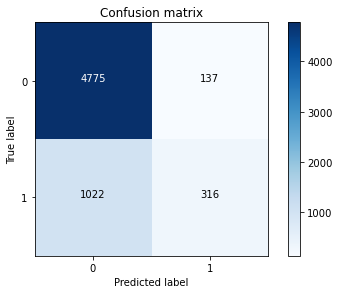

Accuracy: 0.815


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=1, solver='lbfgs',C=1E9,max_iter=1000)
clf.fit(X_train, t_train)    
t_pred=clf.predict(X_val)    
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_val, t_pred) 
print(f'Accuracy: {acc:.3f}')

# Basic Random forest

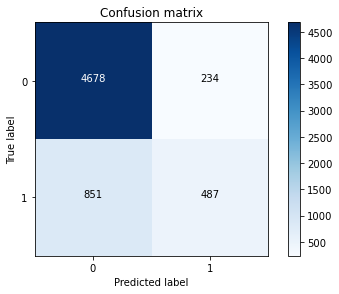

Accuracy: 0.826


In [8]:
from sklearn.ensemble import RandomForestClassifier

# simple fit
rf = RandomForestClassifier(
    n_estimators=200,    
    bootstrap=True,      
    max_features=10,       
    criterion='entropy',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=20,
)

rf.fit(X_train,t_train)
t_pred=rf.predict(X_val)     
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');
plt.show()
acc=accuracy_score(t_val, t_pred)
print(f'Accuracy: {acc:.3f}')

# Basic AdaBoost

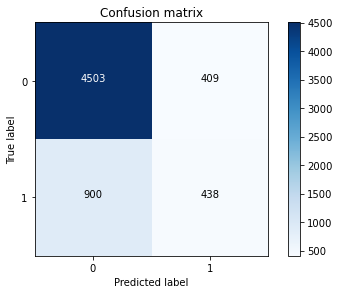

Accuracy: 0.791


In [9]:
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# simple fit
AdaB = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators=50, 
    learning_rate=1.0,
    )

AdaB.fit(X_train,t_train)
t_pred=AdaB.predict(X_val)     
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');
plt.show()
acc=accuracy_score(t_val, t_pred)
print(f'Accuracy: {acc:.3f}')

# Random Forest Classifiere with Grid Search

The following section elaborates on the Random Forest classifier.

The first model includes all the dummy variables, where the non-dummy variables have been normalized. Here, a grid search over a parameter set is performed, to find the optimal hyperparameters.

Next, a random forrest where the data has not been modified at all is used (no standardization or dummification), to see to what extent feature engineering has a positive effect on the performance




## Data exploration

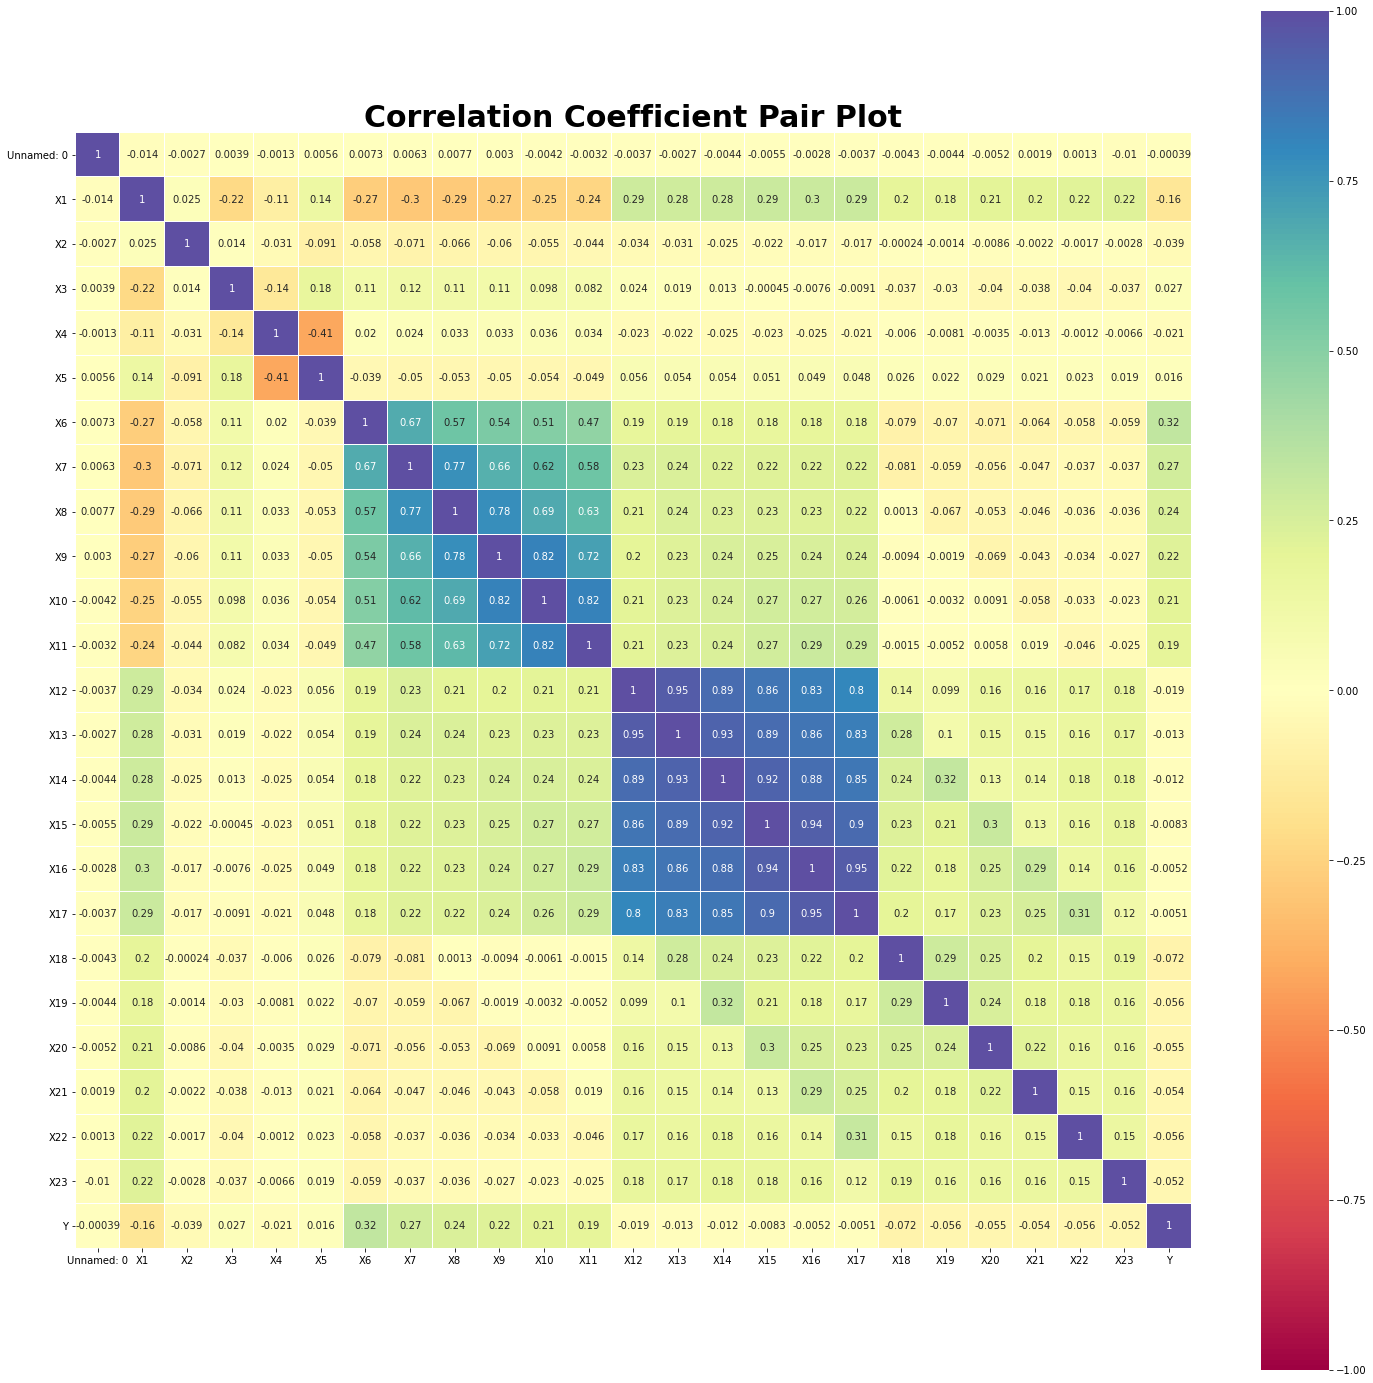

In [10]:
import seaborn as sns
plt.figure(figsize=(25,25))
ax = plt.axes()
corr = df.corr()
sns.heatmap(corr, vmax=1,vmin=-1, square=True, annot=True, cmap='Spectral',linecolor="white", linewidths=0.01, ax=ax)
ax.set_title('Correlation Coefficient Pair Plot',fontweight="bold", size=30)
plt.show()

## RF, standardized and dummified

In [11]:
#### USING GRID SEARCH FOR MODEL WITH DUMMY VARIABLES & NORMALIZED DATA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Method of selecting samples for training each tree
bootstrap = [True]
# Maximum number of levels in tree
max_depth = [5, 20, 50]
# Number of features to consider at every split
max_features = [5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 15]
# Which criterion to use
criterion = ['entropy','gini']
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Number of trees in random forest
n_estimators = [300, 500, 1000]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'criterion' : criterion,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators}
pprint(param_grid)

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)

grid_search.fit(X_train,t_train)
grid_search.best_estimator_

{'bootstrap': [True],
 'criterion': ['entropy', 'gini'],
 'max_depth': [5, 20, 50],
 'max_features': [5, 10, 15],
 'min_samples_leaf': [5, 10, 15],
 'min_samples_split': [5, 10],
 'n_estimators': [300, 500, 1000]}


In [ ]:
### THE OPTIMAL MODEL WITH DUMMIES WITH THE OPTIMAL VALUES FROM GRID SEARCH INCORPORATED
rf = RandomForestClassifier(
           bootstrap = [True],
           max_depth = 5,
           max_features = 15,
           min_samples_leaf = 5,
           criterion = 'entropy',
           min_samples_split = 5,
           n_estimators = 500, warm_start=True, oob_score=True)

### ACCURACY
rf.fit(X_train,t_train)
t_pred=rf.predict(X_val)     
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_val, t_pred)  
print(f'Accuracy: {acc:.3f}')

#### SHOWING THE FEATURE RELEVANCE 
feature_importances = pd.Series(rf.feature_importances_,index=Xlabels).sort_values(ascending=False)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing the importance of features")
# plt.legend()
plt.show()



## Rand Forest, without feature engineering

In [ ]:
###### REMOVE DUMMY VARIABLES AS RF CAN HANDLE THESE ITSELF, NO NORMALIZING
data01=pd.merge(df.loc[:,'X1'],df.loc[:,'X2':'X23'],left_index=True, right_index=True)
df01_t=df['Y']                      
X_new = data01.values   
t_new=df01_t.values
X_new_train, X_new_val, t_new_train, t_new_val = train_test_split(X_new[:25000], t_new[:25000], random_state=1, test_size=0.25)
Xlabels_new=data01.columns

### GRID SEARCH FOR THE NEW SIMPLIFIED MODEL
grid_search.fit(X_new_train,t_new_train)
grid_search.best_estimator_

In [ ]:
### THE OPTIMAL MODEL WITHOUT DUMMIES & NORMALIZATION. Parameters obtained from the grid search are used
rf = RandomForestClassifier(
           bootstrap = [True],
           max_depth = 5,
           max_features = 10,
           min_samples_leaf = 5,
           criterion = 'gini',
           min_samples_split = 10,
           n_estimators = 500,
)

### ACCURACY
rf.fit(X_new_train,t_new_train)
t_new_pred=rf.predict(X_new_val)    
cnf_matrix = confusion_matrix(t_new_val, t_new_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()
acc=accuracy_score(t_new_val, t_new_pred)   
print(f'Accuracy: {acc:.3f}')

### SHOWING THE FEATURE RELEVANCE 
feature_importances = pd.Series(rf.feature_importances_,index=Xlabels_new).sort_values(ascending=False)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing the importance of features")
# plt.legend()
plt.show()